In [1]:
#Imports
import os
import pickle

import cv2
import tensorflow as tf
import numpy as np
import json

from skimage import transform as transf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import random
import csv

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_samples_per_epoch = 16384
valid_samples_per_epoch = 8192
trainBatchSize = 128
validationBatchSize = 128
mean = 83.587824273 #Pre Calculated

xCropUp = .35      # % of crop
xCropBottom = .9   #

imageWidth = 200
imageHeight = 60
list_imgs = []

In [3]:
def ReadAndProcessImage(path):
    img = cv2.imread(path)  # opencv opens images in BGR format
    global list_imgs
    list_imgs.append(img)
    #print(img.shape)
    img = CropImage(img)
    img = cv2.resize(img, (imageWidth, imageHeight))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to standard RGB
    img = np.reshape(img, (1, imageHeight, imageWidth, 3))
    return img

def crop_image(image, y1, y2, x1, x2):
    """
    crop image into respective size
    give: the crop extent
    """
    return image[y1:y2, x1:x2]
def CropImage(image):
    height = len(image)
    #print(height)
    return image[int(height*xCropUp):int(height*xCropBottom), :, :]

def visualize_random_images(list_imgs):
    '''
    list_imgs = list of index of images to be visualized
    '''
    print("number of images: ",len(list_imgs))
    _, ax = plt.subplots( int(len(list_imgs)/2), 2, figsize=(20,40))
    row, col = 0, 0  
    for idx in range(len(list_imgs)):
        img = list_imgs[idx]
        print('r,c: ',row,col,img.shape)
        ax[row,col].imshow(img)
        #ax[row, col].annotate(int(y_dataset[idx]), xy=(2, 5), color='red', fontsize='20')

        ax[row,col].axis('off')
        col += 1
        if col == 2:
            row += 1
            col = 0
    plt.show()
    
def trans_image(steer):
    
    trans_range = 50

    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * .4
    if(steer_ang > 1):
        steer_ang = 1
    elif(steer_ang < -1):
        steer_ang = -1
    
    return steer_ang


In [4]:
dir = './data/'
value = []
with open(dir + 'driving_log.csv', 'r') as drivingLog:
    reader = csv.reader(drivingLog)
    drivingLog = list(reader)
    
dir = './data1/'
with open(dir + 'driving_log.csv', 'r') as drivingLog1:
    reader = csv.reader(drivingLog1)
    drivingLog = list(reader) + drivingLog
dir = './data2/'
with open(dir + 'driving_log.csv', 'r') as drivingLog1:
    reader = csv.reader(drivingLog1)
    drivingLog = list(reader) + drivingLog

dir = './data3/'
with open(dir + 'driving_log.csv', 'r') as drivingLog1:
    reader = csv.reader(drivingLog1)
    drivingLog = list(reader) + drivingLog

dir = './data4/'
with open(dir + 'driving_log.csv', 'r') as drivingLog1:
    reader = csv.reader(drivingLog1)
    drivingLog = list(reader) + drivingLog

dir = './session_data/'
with open(dir + 'driving_log.csv', 'r') as drivingLog1:
    reader = csv.reader(drivingLog1)
    drivingLog = list(reader) + drivingLog
drivingLog = shuffle(drivingLog)

global negative
global positive
negative = 0
positive = 0

zero = 0

drivingLog = shuffle(drivingLog)
for row in drivingLog:
    indx = np.random.permutation(3)
    steering = float(row[3])

    for i in range(3):

        if indx[i] is 1:  # left camera image
            steering = min(1, steering + .25)
        elif indx[i] is 2:  # right camera image
            steering = max(-1, steering - .25)

        file = row[indx[i]]
        if len(file) == 0:
            continue
        #if (steering < -0.9 or steering > 0.1):
            
        choice = random.randint(1, 3)
        if choice == 1:
            value.append(-steering)
            positive += -steering > 0
            negative += -steering < 0

        elif choice == 2:
            value.append(steering)
            positive += steering > 0
            negative += steering < 0                

        '''elif steering == 0:
            zero+=1
            if zero % 50 == 0:
                value.append(steering)
            steering = trans_image(steering)
            if (negative > positive and steering > 0) or (negative < positive and steering < 0):
                value.append(steering)
                positive += steering > 0
                negative += steering < 0'''
print(positive,negative)
value = np.around(np.vstack(np.asarray(value)), decimals=2)


18231 17826


In [5]:
val = value
print(np.unique(val))
len(np.unique(val))
value = np.around(val,decimals=1)
print(np.unique(value))
value *= 10
print(np.unique(value))

[-1.   -0.95 -0.94 -0.93 -0.92 -0.89 -0.84 -0.83 -0.81 -0.8  -0.79 -0.78
 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66
 -0.65 -0.64 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54
 -0.53 -0.52 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42
 -0.41 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3
 -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18
 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06
 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06
  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18
  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3
  0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42
  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54
  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66
  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74  0.7

[[-0.]
 [-0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [-0.]]
classes:  21
-10.0 3
-9.0 11
-8.0 34
-7.0 50
-6.0 129
-5.0 225
-4.0 717
-3.0 1983
-2.0 5352
-1.0 5932
-0.0 71041
1.0 6034
2.0 5502
3.0 2058
4.0 745
5.0 225
6.0 138
7.0 39
8.0 29
9.0 10
10.0 5
21
------- 
Highest count: 71041.0 (class 0)
Lowest count: 3.0 (class 11)
------- 


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


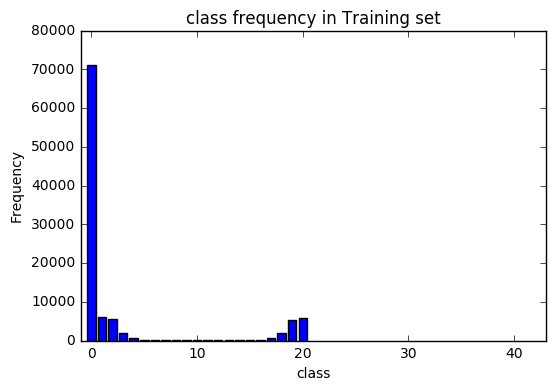

NameError: name 'sign_names' is not defined

In [6]:
from prettytable import PrettyTable
### DATA EXPLORATION : class distribution
num_classes = 0


def get_count_imgs_per_class(y, verbose=False):
    print(y)
    global num_classes
    num_classes = len(np.unique(y))
    print("classes: ",num_classes)
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in np.unique(y):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
        print(this_class,np.sum(y == this_class ))
    #sanity check
    return count_imgs_per_class


class_freq = get_count_imgs_per_class(value)
print(num_classes)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(num_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i in range(len(sign_names)):
    sign_name_table.add_row([sign_names[i][0], sign_names[i][1]] )
    
print(sign_name_table)

#### 

## from prettytable import PrettyTable
### DATA EXPLORATION : class distribution
num_classes = 0


def get_count_imgs_per_class(y, verbose=False):
    print(y)
    global num_classes
    num_classes = len(np.unique(y))
    print("classes: ",num_classes)
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in np.unique(y):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
    #sanity check
    return count_imgs_per_class


class_freq = get_count_imgs_per_class(value)
print(num_classes)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(num_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i in range(len(sign_names)):
    sign_name_table.add_row([sign_names[i][0], sign_names[i][1]] )
    
print(sign_name_table)

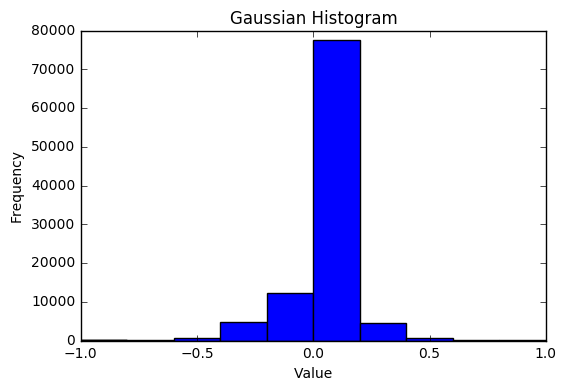

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#import plotly.plotly as py
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api


plt.hist(val)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

fig = plt.gcf()

#plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

In [53]:
# visualize

values = []

dir = './data/'
with open(dir+'driving_log.csv', 'r') as drivingLog:
    reader = csv.reader(drivingLog)
    drivingLog = list(reader)
    drivingLog = shuffle(drivingLog)
    batchx , batchy= [], []
    ind = 0
    row, col = 0, 0 
    print(type(row))
    for row in drivingLog:
        indx = np.random.permutation(3)
        steering = float(row[3])
        values.append(steering)
            
            
            
        #if(ind == 2):
        #    break
    #visualize_random_images(list_imgs)
            

<class 'int'>


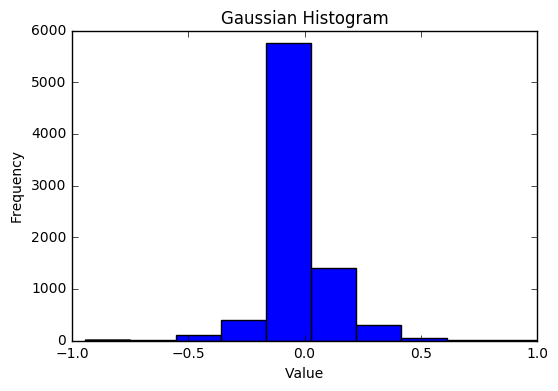

In [54]:
import matplotlib.pyplot as plt
import numpy as np

#import plotly.plotly as py
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

gaussian_numbers = np.random.randn(1000)
plt.hist(values)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

fig = plt.gcf()

#plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

In [55]:
def DataGenerator(dir,batchSize):
    #dir = './session_data/'
    with open(dir+'driving_log.csv', 'r') as drivingLog:
        reader = csv.reader(drivingLog)
        drivingLog = list(reader)
    while True:
        batchx , batchy= [], []
        for row in drivingLog:
            indx = np.random.permutation(3)
            steering = float(row[3])

            for i in range(3):
                file = row[indx[i]]
                img = ReadImage(dir+file)
                if indx[i] is 1:
                    steering += .25
                elif indx[i] is 2:
                    steering -= .25

                #batchx.append(img / 127.5 - 1.)
                batchx.append(img)
                batchy.append(steering)

                # Decrease Brightness

                img[:, :, 2] = img[:,:,2] * .5
                #img = img / 127.5 - 1.
                batchx.append(img)
                batchy.append(steering)

                if (len(batchx) == batchSize):
                    batchx[:] = [x - mean for x in batchx]
                    if (dir == './session_data/'):
                        global totalTrain
                        totalTrain += len(batchx)
                        print("Training: total: ", totalTrain)
                    else:
                        global totalValid
                        totalValid += len(batchx)
                        print("Validation: total: ", totalValid)
                    yield (np.vstack(batchx),np.vstack(batchy))
                    batchx, batchy= [],[]


In [56]:
# TODO: Build a model
print("Creating Convnet Model")

model = Sequential()
model.add(Convolution2D(32, 5, 5, input_shape=(160, 320, 3), subsample=(1, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(1, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))

model.add(Convolution2D(64, 5, 5, subsample=(2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))

model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))

print("Creating FC Model")

model.add(Flatten())

model.add(Dense(2048, W_regularizer=l2(.01)))
model.add(Activation('relu'))

model.add(Dense(1024, W_regularizer=l2(.01)))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(Dropout(0.3))

model.add(Dense(128, W_regularizer=l2(.01)))
model.add(Activation('relu'))

model.add(Dense(32, W_regularizer=l2(.01)))
model.add(Activation('relu'))

model.add(Dense(10, W_regularizer=l2(.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

Creating Convnet Model
Creating FC Model


model.compile(optimizer="adam", loss="mse")

#mean =  MeanCalculator() # calculated once
print('mean: ',mean)
totalTrain = 0
totalValid = 0

trainGenerator = DataGenerator('./session_data/',trainBatchSize)
validGenerator = DataGenerator('./data/',validationBatchSize)

print("Created generator and starting training")

model.fit_generator(
	trainGenerator,
	samples_per_epoch=train_samples_per_epoch, nb_epoch=50,
	validation_data=validGenerator,
	nb_val_samples=valid_samples_per_epoch, verbose=2
)


model.save_weights('kerasmodel', True)
with open('kerasmodel.json', 'w') as file:
	json.dump(model.to_json(), file)
